In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from functools import partial
# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import PlotDefault
import NeuralNet
from Numerics import gradient_first


# Load data

In [2]:
N_y = 384
beta = 1.0
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]

omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
q_jet = omega_jet + beta*yy




tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]
N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])
d_closure_mean = np.copy(closure_mean)
for i in range(N_data):  
    d_closure_mean[i, :] = gradient_first(closure_mean[i, :], dy, bc = "one-sided")
    
# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean[i, 0:chop_l] = np.linspace(beta, dq_dy_mean[i,chop_l-1],  chop_l)
    dq_dy_mean[i, -chop_l:] = np.linspace(dq_dy_mean[i, -chop_l], beta, chop_l)
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean

# TODO: clip and filter the data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)
    
    
    
    

    
tau_inv = [0.005, 0.06, 0.2]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]
N_data = len(data_dirs)
closure_mean_test,  q_mean_test, dq_dy_mean_test = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean_test[i, :], q_mean_test[i, :], dq_dy_mean_test[i, :] = load_data(data_dirs[i])
d_closure_mean_test = np.copy(closure_mean_test)
for i in range(N_data):  
    d_closure_mean_test[i, :] = gradient_first(closure_mean_test[i, :], dy, bc = "one-sided")

# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean_test[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean_test[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean_test[i, -chop_l:] = np.linspace(q_mean_test[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean_test[i, 0:chop_l] = np.linspace(beta, dq_dy_mean_test[i,chop_l-1],  chop_l)
    dq_dy_mean_test[i, -chop_l:] = np.linspace(dq_dy_mean_test[i, -chop_l], beta, chop_l)
    
q_mean_abs_test = np.fabs(q_mean_test)  
mu_f_test = closure_mean_test/dq_dy_mean_test

# TODO: clip and filter the data
mu_f_test[mu_f_test >= 0.1 ] = 0.0
mu_f_test[mu_f_test <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f_test[i,:] = scipy.ndimage.gaussian_filter1d(mu_f_test[i,:], 5)
    
    
    

# Visualize data

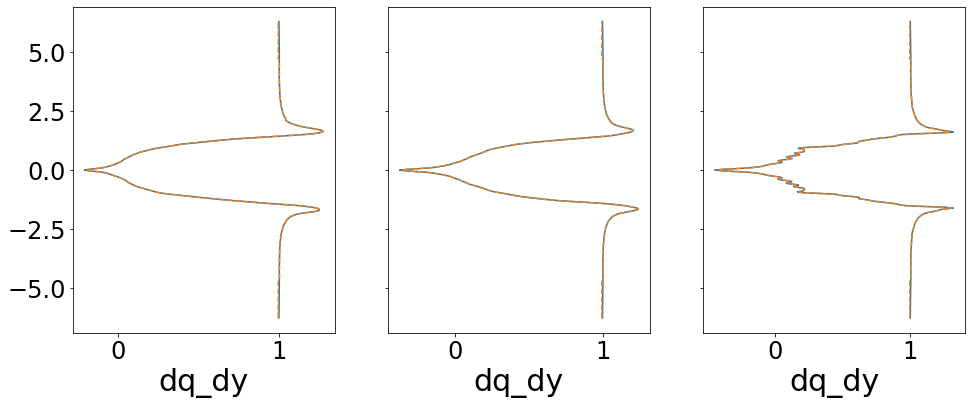

In [3]:
# compare dq_dy_mean vs dq_dy
dq_mean_dy = np.zeros(dq_dy_mean.shape)
for i in range(N_data): 
    dq_mean_dy[i, :] = gradient_first(q_mean[i, :], dy, bc = "one-sided")

fig, ax = plt.subplots(nrows=1, ncols=N_data, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[i].plot(dq_dy_mean[i,:], yy)
    ax[i].plot(dq_mean_dy[i,:], yy, "--")
    ax[i].set_xlabel("dq_dy")
    

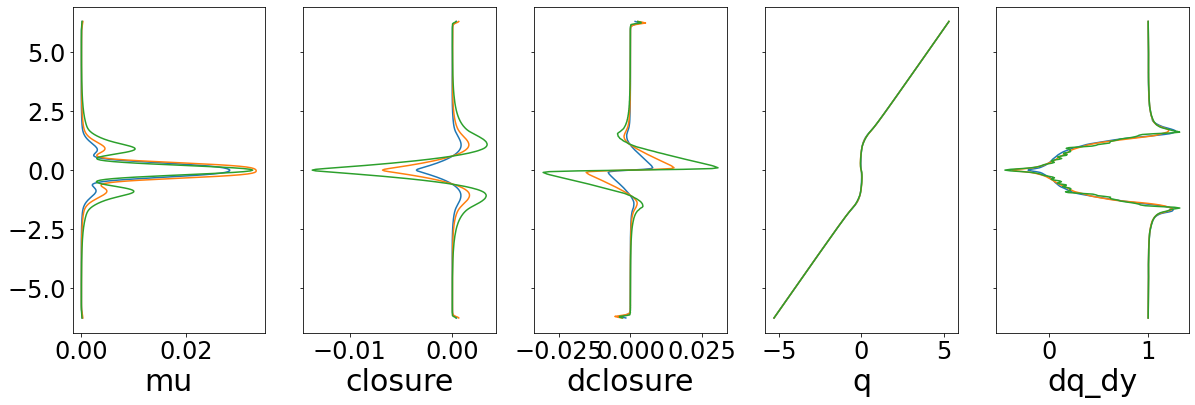

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(20,6))
for i in range(N_data):
    ax[0].plot(mu_f[i,:], yy)
    ax[1].plot(closure_mean[i,:], yy)
    ax[2].plot(d_closure_mean[i,:], yy)
    ax[3].plot(q_mean[i,:], yy)
    ax[4].plot(dq_dy_mean[i,:], yy)
    
    
    ax[0].set_xlabel("mu")
    ax[1].set_xlabel("closure")
    ax[2].set_xlabel("dclosure")
    ax[3].set_xlabel("q")
    ax[4].set_xlabel("dq_dy")


In [ ]:
# Training nerual networks

In [18]:
for nn_save_name in ["diffusivity.nn", "flux.nn", "source.nn"]:

    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity.nn":        
        x_train =  np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T 
        y_train =  mu_f.flatten()[:,np.newaxis].astype(np.float32)/mu_scale


    elif nn_save_name == "flux.nn":
        x_train = np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T.astype(np.float32)
        y_train = closure_mean.flatten()[:,np.newaxis].astype(np.float32)/flux_scale

    elif nn_save_name == "source.nn":
        x_train = np.stack((q_mean.flatten(), dq_dy_mean.flatten())).T.astype(np.float32) 
        y_train = d_closure_mean.flatten()[:,np.newaxis].astype(np.float32)/source_scale

    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")


    x_train = torch.from_numpy(x_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    ind = x_train.shape[1]
    outd = y_train.shape[1] 

    learning_rate = 0.001
    step_size = 100
    gamma = 0.5  
    epochs = 20000
    batch_size = 64

    net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        net.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:

            optimizer.zero_grad()
            out = net(x)

            loss = myloss(out , y)*100
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()


        if ep % 1000 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
            if nn_save_name is not None:
                torch.save(net, nn_save_name)



start train nn :  source.nn
Epoch :  0  Epoch time :  0.060050188563764095  Train L2 Loss :  28634.468505859375
Epoch :  1000  Epoch time :  0.0396293206140399  Train L2 Loss :  283.6860680580139
Epoch :  2000  Epoch time :  0.03968666400760412  Train L2 Loss :  173.51709604263306
Epoch :  3000  Epoch time :  0.03990362770855427  Train L2 Loss :  163.1314867734909
Epoch :  4000  Epoch time :  0.03965016454458237  Train L2 Loss :  158.79846501350403
Epoch :  5000  Epoch time :  0.03966924734413624  Train L2 Loss :  156.6264374256134
Epoch :  6000  Epoch time :  0.03983811940997839  Train L2 Loss :  151.17823481559753
Epoch :  7000  Epoch time :  0.03963926061987877  Train L2 Loss :  146.39893674850464
Epoch :  8000  Epoch time :  0.039602553471922874  Train L2 Loss :  140.66889119148254
Epoch :  9000  Epoch time :  0.039760262705385685  Train L2 Loss :  138.85666489601135
Epoch :  10000  Epoch time :  0.04245011601597071  Train L2 Loss :  136.46989637613297
Epoch :  11000  Epoch time : 

# Direct Test

start train nn :  diffusivity.nn
start train nn :  flux.nn
start train nn :  source.nn


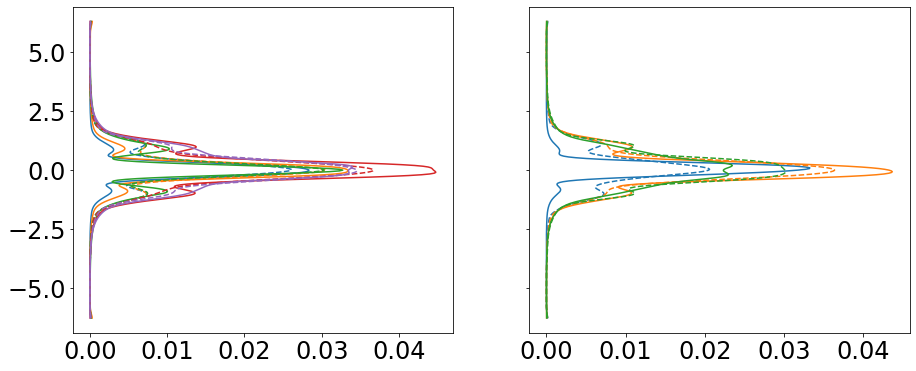

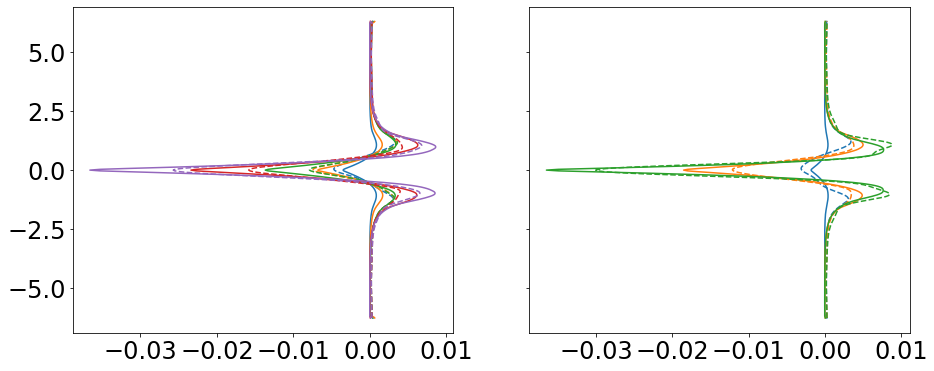

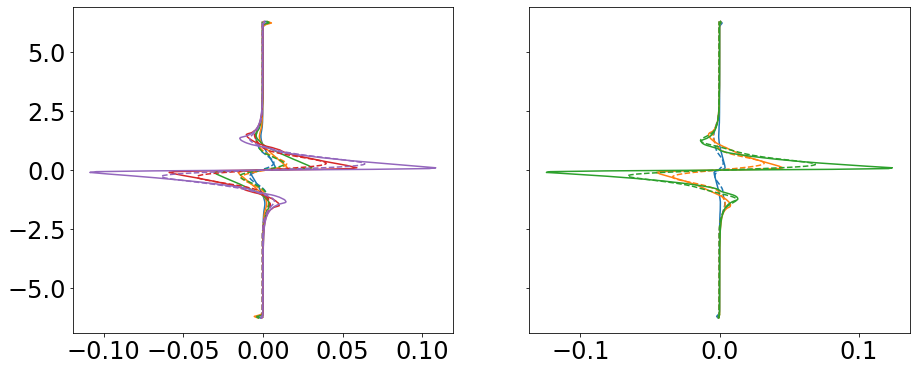

In [5]:
for nn_save_name in ["diffusivity.nn", "flux.nn", "source.nn"]:
    trained_net = torch.load(nn_save_name)
    
    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity.nn":        
        x_train  =  np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T 
        y_train_raw =  mu_f
        y_train   =  mu_f.flatten()[:,np.newaxis].astype(np.float32)/mu_scale
        
        x_test  =  np.stack((q_mean_abs_test.flatten(), dq_dy_mean_test.flatten())).T 
        y_test_raw =  mu_f_test
        y_test   =  mu_f_test.flatten()[:,np.newaxis].astype(np.float32)/mu_scale
        
        scale = mu_scale
        non_negative = True
    elif nn_save_name == "flux.nn":
        x_train = np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T.astype(np.float32)
        y_train_raw = closure_mean
        y_train = closure_mean.flatten()[:,np.newaxis].astype(np.float32)/flux_scale
        
        x_test = np.stack((q_mean_abs_test.flatten(), dq_dy_mean_test.flatten())).T.astype(np.float32)
        y_test_raw = closure_mean_test
        y_test = closure_mean_test.flatten()[:,np.newaxis].astype(np.float32)/flux_scale
        
        
        scale = flux_scale
        non_negative = False
    elif nn_save_name == "source.nn":
        x_train = np.stack((q_mean.flatten(), dq_dy_mean.flatten())).T.astype(np.float32) 
        y_train_raw = d_closure_mean
        y_train = d_closure_mean.flatten()[:,np.newaxis].astype(np.float32)/source_scale
        
        x_test = np.stack((q_mean_test.flatten(), dq_dy_mean_test.flatten())).T.astype(np.float32) 
        y_test_raw = d_closure_mean_test
        y_test = d_closure_mean_test.flatten()[:,np.newaxis].astype(np.float32)/source_scale
        
        
        scale = source_scale
        non_negative = False
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
    
    fig, ax = plt.subplots(ncols=2, sharey=True, nrows=1, figsize=((15,6)))
    
    N_data = q_mean_abs.shape[0]  
    y_train_pred = NeuralNet.net_eval(net=trained_net, x=x_train, mu_scale=scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_data).reshape((N_data, N_y))
    for i in range(N_data):
        ax[0].plot(y_train_raw[i,:], yy, color="C"+str(i))
        ax[0].plot(y_train_pred[i,:], yy, "--", color="C"+str(i))
    

    N_data = q_mean_abs_test.shape[0]  
    y_test_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_data).reshape((N_data, N_y))
    for i in range(N_data):
        ax[1].plot(y_test_raw[i,:], yy, color="C"+str(i))
        ax[1].plot(y_test_pred[i,:], yy, "--", color="C"+str(i))
    
    
#         ax[0].set_xlabel("closure")
#         ax[1].set_xlabel("mu")
    
    
    



# Plug-in Test

In [4]:
beta = 1.0
def point_jet(tau_inv, nn_save_name):
    trained_net = torch.load(nn_save_name)
    
    print("start ", tau_inv)

    Nx = 384
    omega_jet = np.zeros(Nx)
    omega_jet[0:Nx//2] = 1.0
    omega_jet[Nx//2:Nx] = -1.0
    L = 4*np.pi
    yy = np.linspace(-L/2.0, L/2.0, Nx)
    q_jet = omega_jet + beta*yy

    tau = 1/float(tau_inv)

    if nn_save_name  == "diffusivity.nn":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=True, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, yy, res : nummodel(nn_model, q, yy, res)
    elif nn_save_name  == "flux.nn":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
    elif nn_save_name  == "source.nn":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = source_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, yy, res : nummodel_source(nn_model, q, yy, res)
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
            
            

    dt, Nt, save_every = 1.0e-4, 200000, 1000
    yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = L)
    q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)
    
    
    return yy,  q_mean_pred, q_pred

    

start  0.005
start  0.06
start  0.2
start  0.005
start  0.06
start  0.2
start  0.005
start  0.06
start  0.2


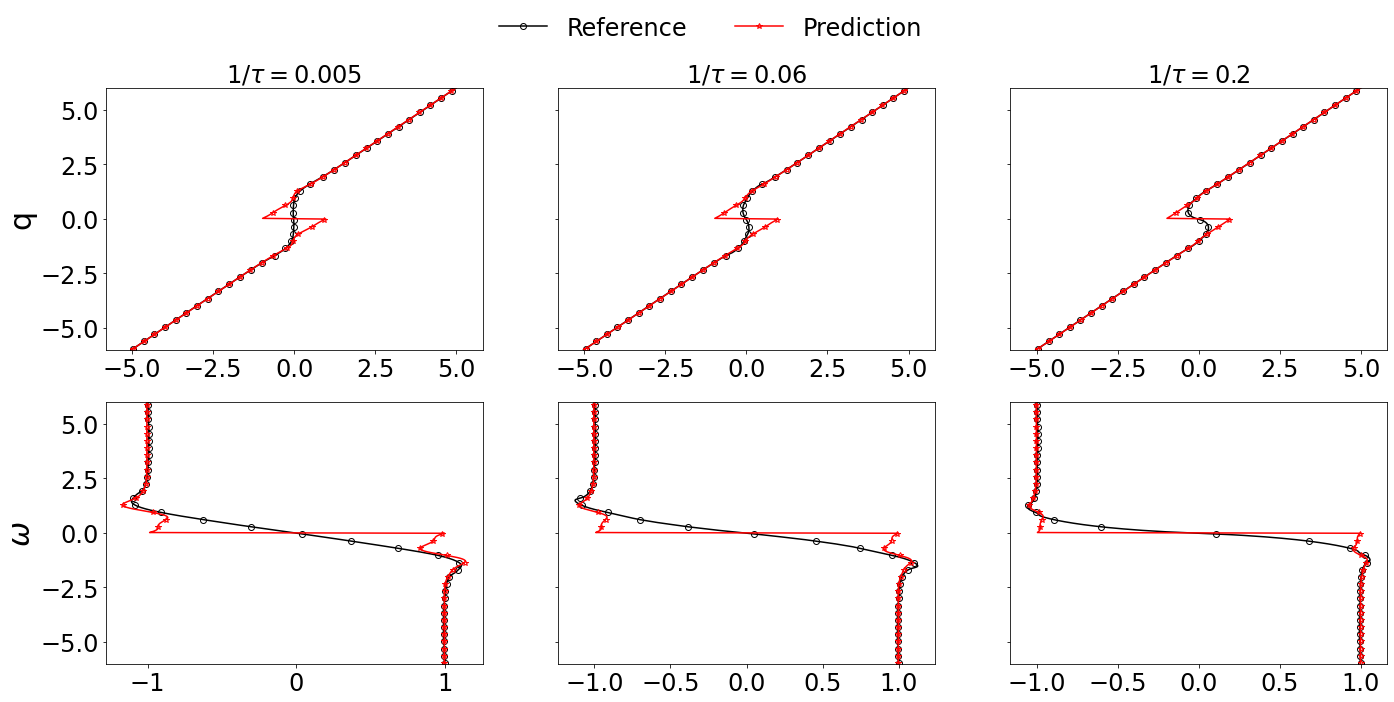

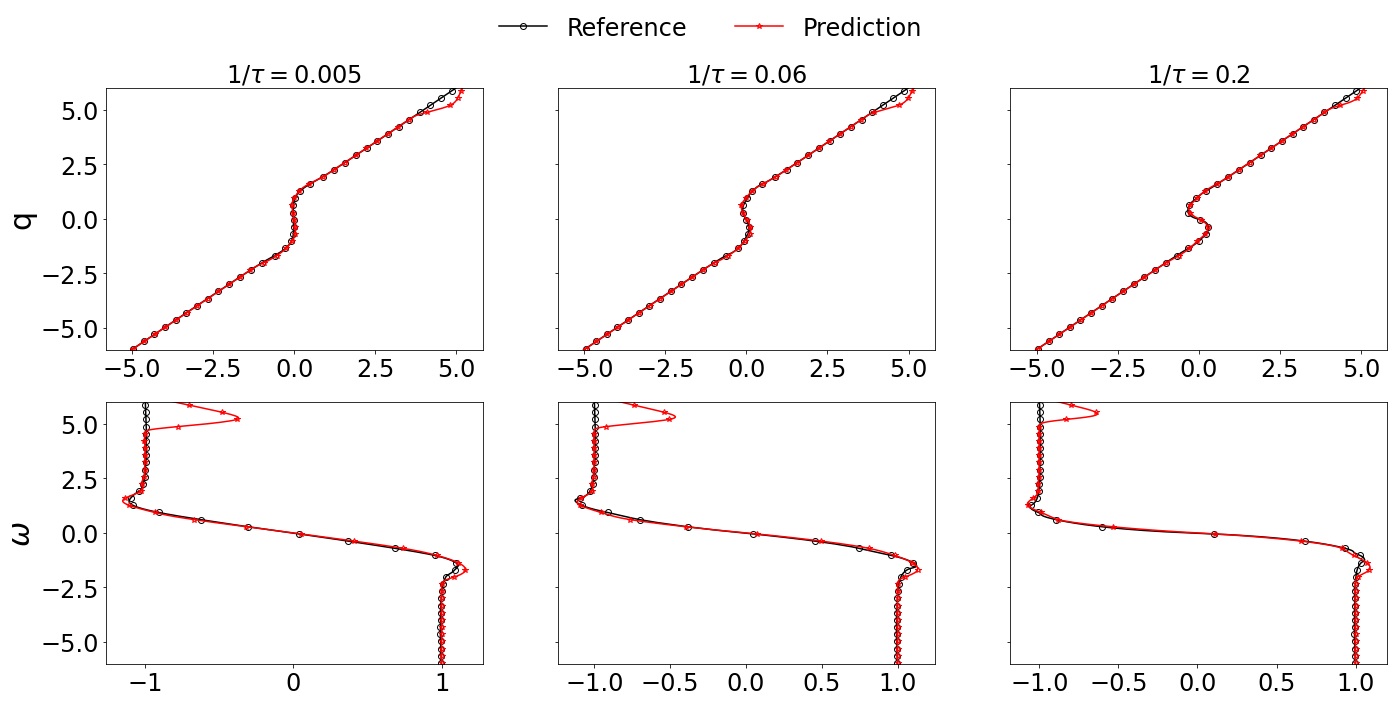

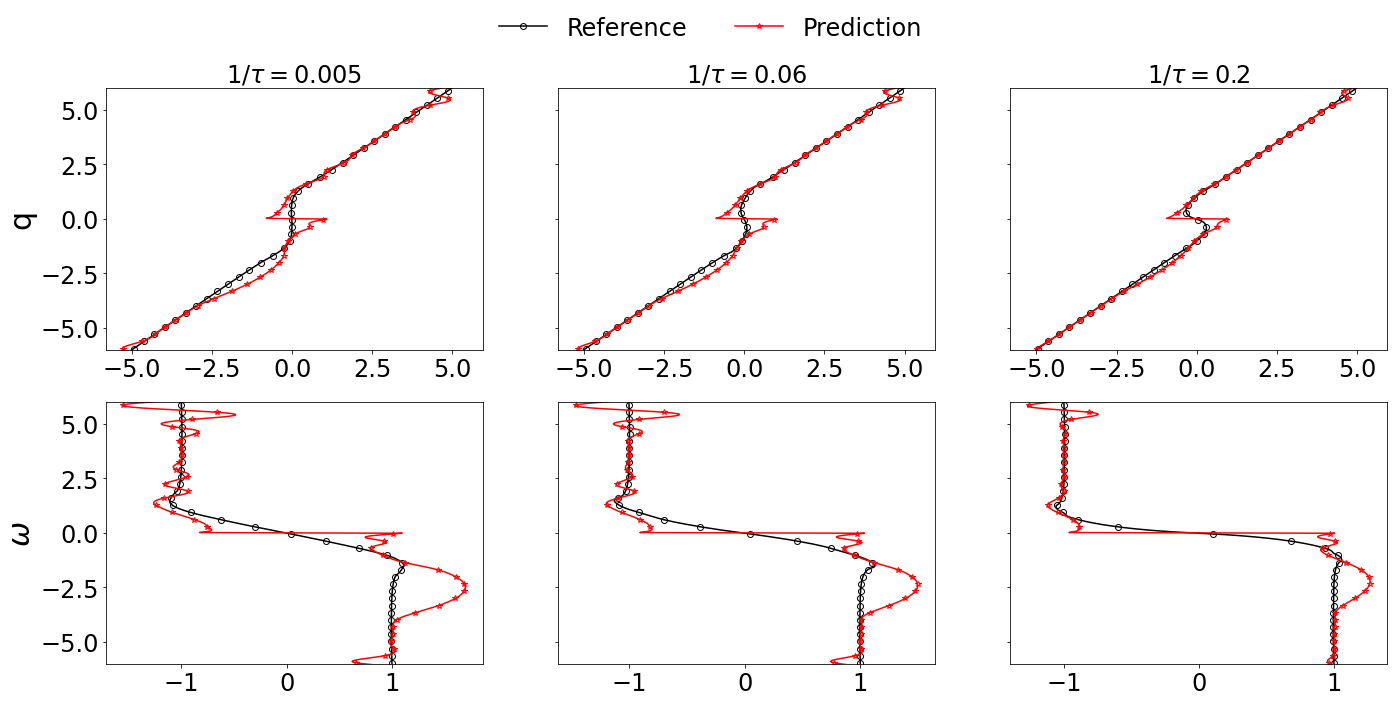

In [5]:
for nn_save_name in ["source.nn", "diffusivity.nn", "flux.nn"]:
    

    tau_invs = ["0.005", "0.06", "0.2"]
    q_mean_pred =  np.zeros((len(tau_invs), N_y))


    for i in range(len(tau_invs)):
        _, q_mean_pred[i,:], _ = point_jet(tau_invs[i], nn_save_name)



    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(20,10))
    markevery = 10

    omega_mean_test = np.copy(q_mean_test)
    omega_mean_pred = np.copy(q_mean)

    for i in range(3):
        omega_mean_test[i,:] = q_mean_test[i,:] - beta*yy
        omega_mean_pred[i,:] = q_mean_pred[i,:] - beta*yy

        color, marker, label = "black", "o", "Reference"
        ax[0, i].plot(q_mean_test[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
        ax[1, i].plot(omega_mean_test[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color)

        color, marker, label = "red", "*", "Prediction"
        ax[0, i].plot(q_mean_pred[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
        ax[1, i].plot(omega_mean_pred[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)


        ax[0, i].set_title(r"$1/\tau = $"+tau_invs[i])

    ax[0, 0].set_ylabel("q")
    ax[1, 0].set_ylabel(r"$\omega$")

    ax[0, 0].set_ylim([-6.0,6.0])
    ax[1, 0].set_ylim([-6.0,6.0])

    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.subplots_adjust(bottom=0.05,top=0.85,left=0.08,right=0.97)
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)
